# Process Data for Different River Basins for the Terrestrial Water Storage S2S Project

## Start Clean

In [1]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from IPython.display import display
import requests
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# For mask creation
import geopandas as gpd
from geocube.api.core import make_geocube

# Borders for mapping: Cultural borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# Coastline
newcoast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k',
                                        facecolor='none')
#Lakes
newlake = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                        facecolor='none')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(ax, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    ax.plot(xs,ys,color='k',linestyle='--',linewidth=3,transform=ccrs.PlateCarree())

def plot_point(ax,lon,lat):
    xs = [lon]
    ys = [lat]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    #ax.scatter(xs,ys,color=np.array([0.5,0.5,0.5]),marker='*',linewidth=3,transform=ccrs.PlateCarree())
    ax.scatter(xs,ys,color='k',edgecolors='k',marker='+',linewidth=0.5,s=5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.5)

ocean_color = np.float64([209,230,241])/255
nmap=plt.cm.get_cmap(name=plt.cm.BrBG,lut=12) # only needed to set bins for pcolor/pcolormesh
      
# Month Vector
mons     = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# For Seasonal Plots
#mons_txt  = np.array(['J','F','M','A','M','J','J','A','S','O','N','D', \
#                        'J','F','M','A','M','J','J','A','S','O','N','D'])
mons_txt  = np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

# Set plot styles
# Formatting for titles
fontdict_title = {'fontsize': 36}
fig_size = np.array([10,10])

# Formatting for figures
style_new = {'xtick.direction': 'in', \
             'ytick.direction': 'in', \
             'font.sans-serif': 'Arial'}


## Load River Basin Shape File

In [2]:
# File Name
countr_dir = '../mrb_shp_zip/mrb_basins.shp'
    
# Load Data
gdf_cnt = gpd.read_file(countr_dir)
gdf_cnt['value'] = 1

# Display to Screen to Check
#display(gdf_cnt)

# Print List of Basins
print(np.unique(gdf_cnt['RIVER_BASI']))

# List of basins to process
basin_list = np.array(['LIMPOPO','ORANGE','JUBBA (also GENALE WENZ)','NILE'])


['ABHE BAD (also ABHE BID HAYK)' 'ACARAU' 'AISEN' 'ALAKOL' 'ALAZEYA'
 'ALBANY' 'ALSEK' 'ALTAMAHA' 'AMACURO (also AMAKURA)'
 'AMAZON (also AMAZONAS)' 'AMUR' 'ANABAR' 'ANADYR' 'ANDERSON'
 'ANGERMANALVEN' 'APALACHICOLA' 'ARAGUARI' 'ARAL SEA' 'ARMERIA' 'ARNAUD'
 'ASHBURTON' 'ATOUI' 'ATRATO' 'ATREK' 'ATTAWAPISKAT' 'AZOPARDO' 'BACK'
 'BAKER' 'BALEINE, GRANDE RIVIERE DE LA' 'BALEINE, RIVIERE DE LA'
 'BANCANNIA LAKE' 'BANDAMA' 'BARAKA' 'BARIMA' 'BENGAWAN SOLO' 'BIA'
 'BIOBIO' 'BLACKWOOD' 'BLANCA' 'BRAHMANI' 'BRAHMAPUTRA' 'BRANTAS' 'BRAZOS'
 'BULLER' 'BULUNGAN' 'BURDEKIN' 'BUZI (also BUDZI)' 'CANCOSA' 'CANDELARIA'
 'CANETE' 'CANIAPISCAU' 'CAPE FEAR' 'CAPIM' 'CATATUMBO' 'CAUVERY'
 'CAVALLY' 'CESTOS (also NUON)' 'CHAD' 'CHANGUINOLA' 'CHAO PHRAYA'
 'CHELIF' 'CHERGUI' 'CHEW BAHIR (also LAKE STEFANIE)' 'CHICO'
 'CHILOANGO (also SHILOANGO, also LOUANGO)' 'CHIRA' 'CHOLUTECA' 'CHUBUT'
 'CHURCHILL' 'CHUY (also SHU)' 'CISNES' 'CLUTHA' 'COATAN' 'COCO' 'COIG'
 'COLORADO' 'COLORADO (also COLORADO RIVER)' 'C

## Example Grid

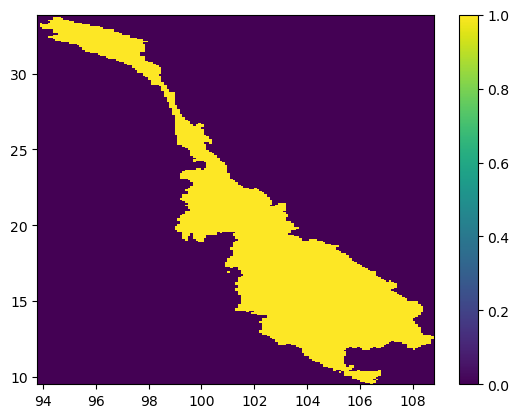

In [3]:
# Create Mask
out_grid = make_geocube(
    #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='COLORADO (also COLORADO RIVER)'],
    vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='MEKONG'],
    measurements=["value"],
    resolution=(-0.1, 0.1),
    fill=0
    )

# Pull out lat/lon/mask as numpy arrays
lat_cnt  = np.flipud(np.array(out_grid.y))
lon_cnt  = np.array(out_grid.x)
grid_cnt = np.flipud(np.array(out_grid.value))
plt.pcolor(lon_cnt,lat_cnt,grid_cnt)
plt.colorbar()


## Precipitation (FLDAS)

LIMPOPO
ORANGE
JUBBA (also GENALE WENZ)
NILE


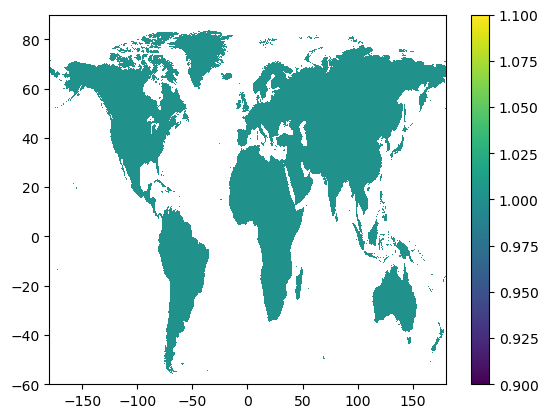

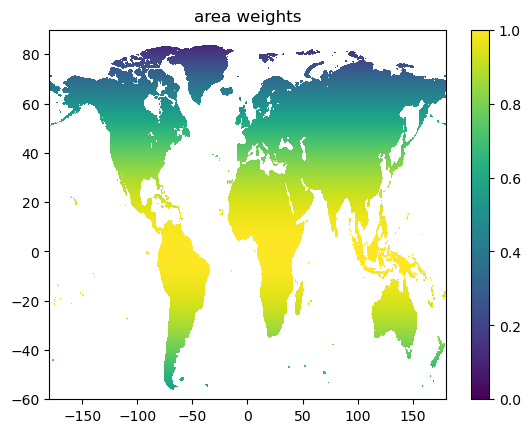

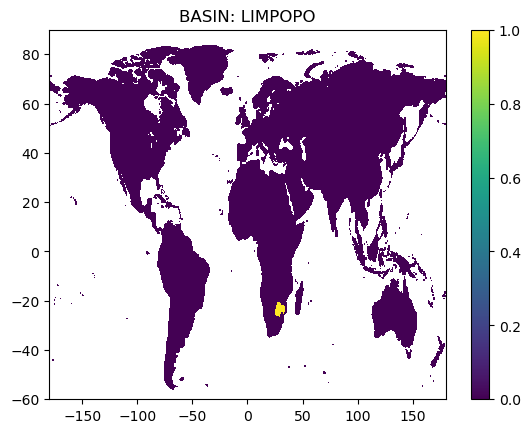

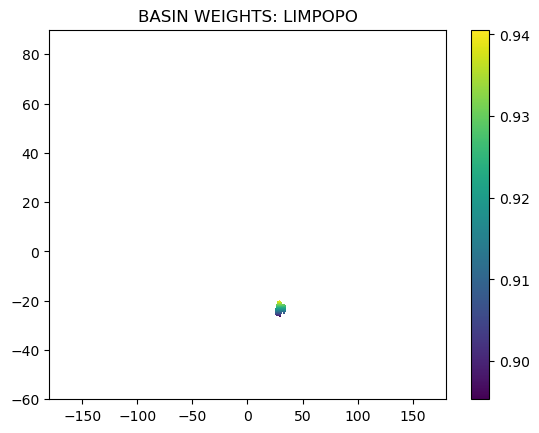

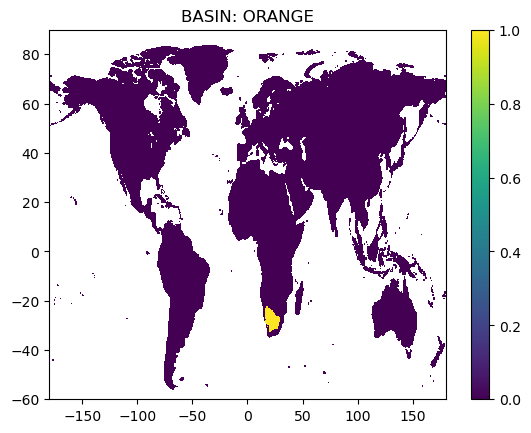

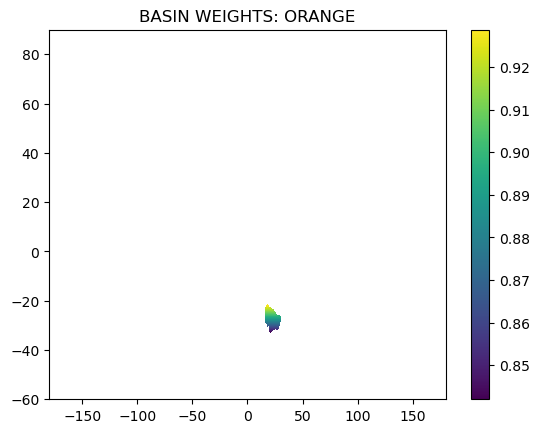

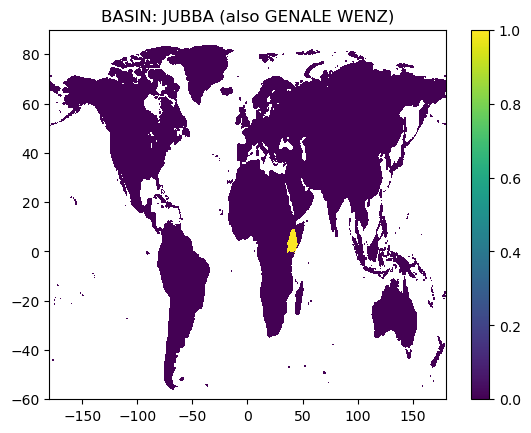

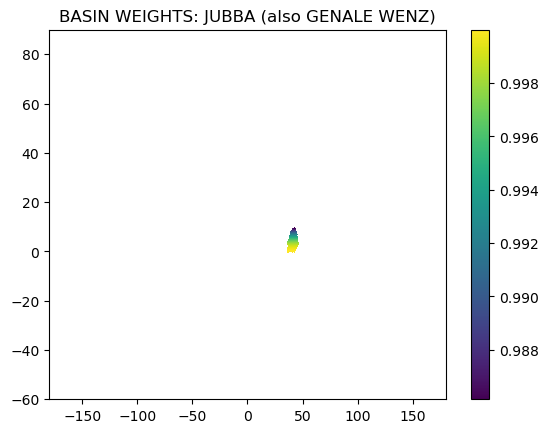

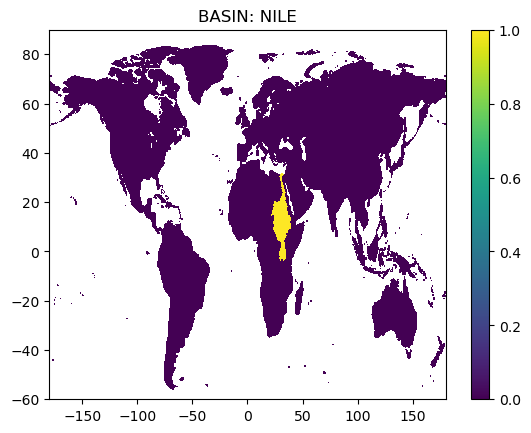

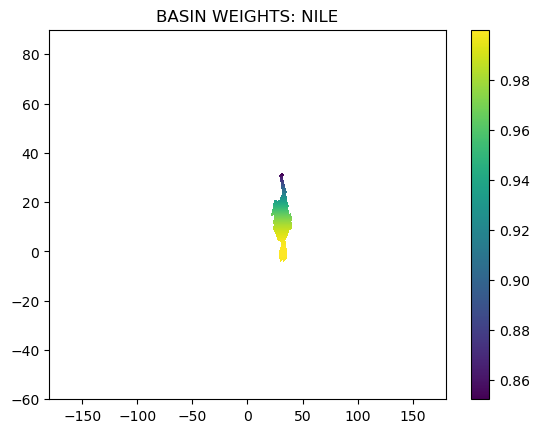

In [4]:
# (1) Create a land sea mask for the current dataset
fname_in  = '../../../GEODATA/FLDAS/monthly/FLDAS_NOAH01_C_GL_M.A198201.001.nc'
data_nc   = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon       = data_nc.variables['X'][:] # get values
lat       = data_nc.variables['Y'][:] # get values
mask_data = np.squeeze(data_nc.variables['Rainf_f_tavg'][:]) # get values
data_nc.close()

# Create uniform spaces lat/lons (minor precisions issues, so slightly uneven spacing in data)
# make sure only goes to 2 decimal places
lat = np.arange(-59.95,89.95+.1,.10);     lat = np.round(lat*100)/100
lon = np.arange(-179.95,179.95+.1,.10);   lon = np.round(lon*100)/100

# Create binary mask for ocean grid cells
mask_data = (mask_data.data)
mask_data[mask_data<0]=np.nan
mask_data[mask_data>=0]=1.0
plt.figure(),plt.pcolormesh(lon,lat,mask_data),plt.colorbar()

# Create latitude/longitude weighting mask
# Use land sea mask to create area weighting
lat_wts    = (np.cos(np.radians(lat)))
wts_global = np.expand_dims(lat_wts,1)*mask_data
plt.figure(),plt.title('area weights'),plt.pcolor(lon,lat,wts_global,vmin=0,vmax=1),plt.colorbar()

# Lon and lat resolution (for basin mask)
lat_res = 0.1
lon_res = 0.1

# Years Covered By Data
yrs_data = np.arange(1982,2022+1)

# LOOP THOUGH EACH BASIN
for n_basin in enumerate(basin_list):
    # Pull out current basin name
    curr_basin = n_basin[1]; print(curr_basin)

    # Create Initial mask for current basin
    # Create Mask
    out_grid = make_geocube(
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='COLORADO (also COLORADO RIVER)'],
        vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']==curr_basin],
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='MEKONG'],
        measurements=["value"],
        #resolution=(-0.25, 0.25),
        resolution=(lat_res, lon_res),
        fill=0
        )
    
    # Pull out lat/lon/mask as numpy arrays: make sure lat orientation matches dataset (use flipud if needed)
    lat_cnt  = np.array(out_grid.y);   lat_cnt = np.round(lat_cnt*100)/100
    lon_cnt  = np.array(out_grid.x);   lon_cnt = np.round(lon_cnt*100)/100
    grid_cnt = np.array(out_grid.value)
    #plt.figure(),plt.pcolor(lon_cnt,lat_cnt,grid_cnt)
        
    # Overlapping lat/lons
    # Set lat/lons to copy
    i_lat = np.nonzero(np.in1d(lat,lat_cnt))[0]
    i_lon = np.nonzero(np.in1d(lon,lon_cnt))[0]
    
    # Apply to global lsmask
    lsmask_basin = mask_data.copy()
    lsmask_basin[np.ix_(i_lat,i_lon)] = lsmask_basin[np.ix_(i_lat,i_lon)]+grid_cnt
    lsmask_basin[np.where(lsmask_basin==1)]=0.0
    lsmask_basin[np.where(lsmask_basin==2)]=1
    plt.figure(),plt.title('BASIN: '+curr_basin),plt.pcolor(lon,lat,lsmask_basin),plt.colorbar()
    lsmask_basin[np.where(lsmask_basin==0)]=np.nan
    
    # Apply to area weighting
    wts_basin = wts_global*lsmask_basin
    plt.figure(),plt.title('BASIN WEIGHTS: '+curr_basin),plt.pcolor(lon,lat,wts_basin),plt.colorbar()    
    
    # Year/Month Loop to load in data
    prec_out = np.zeros((yrs_data.size,mons.size))
    
    # Year/mon loops
    for n_yr in enumerate(yrs_data):
                
        # Month Loop
        for n_mon in enumerate(mons):
            
            # Year+Month Text String
            if n_mon[1]<10:
                str_yrmon = str(n_yr[1])+'0'+str(n_mon[1])
            elif n_mon[1]>=10:
                str_yrmon = str(n_yr[1])+str(n_mon[1])

            # Text string for datafile
            str_datafile = '/Users/bcook/Dropbox/GEODATA/FLDAS/monthly/FLDAS_NOAH01_C_GL_M.A'+str_yrmon+'.001.nc'
            #print(str_datafile)
            data_nc      = netCDF4.Dataset(str_datafile,"r",format="NETCDF4")
            prec_data    = np.squeeze(data_nc.variables['Rainf_f_tavg'][:])+np.squeeze(data_nc.variables['Snowf_tavg'][:]) # get values
            data_nc.close()
            
            # Convert Precipitation to mm/day
            prec_data = prec_data*86400

            # Weighted average
            prec_out[n_yr[0],n_mon[0]] = np.nansum(prec_data*wts_basin)/np.nansum(wts_basin)
    
    # Save dataframe and export to csv file
    data_out = np.hstack((np.expand_dims(yrs_data,1),prec_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/prec_fldas_mm_day_'+curr_basin+'.csv',index=False)


## Soil Moisture (GLEAM)

LIMPOPO
ORANGE
JUBBA (also GENALE WENZ)
NILE


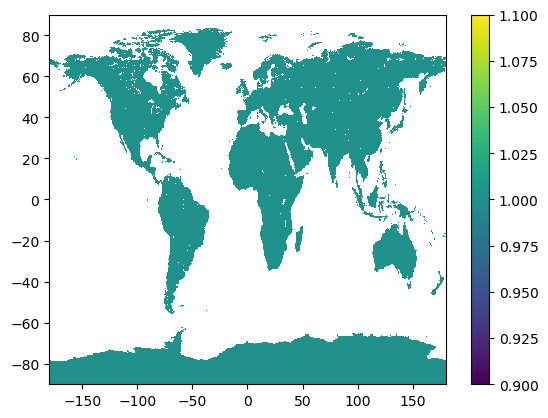

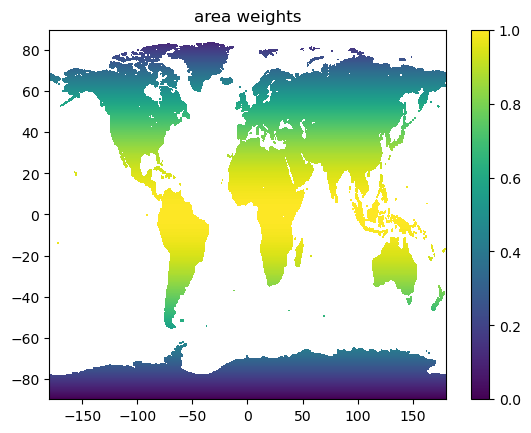

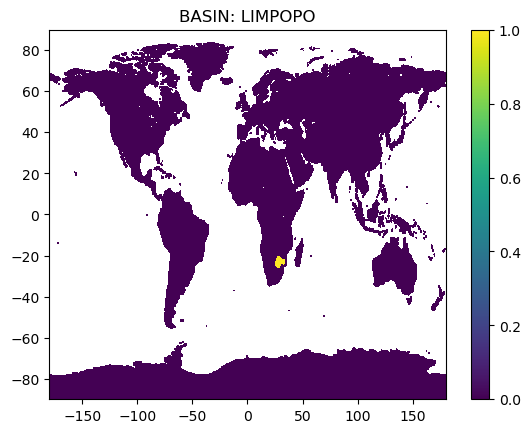

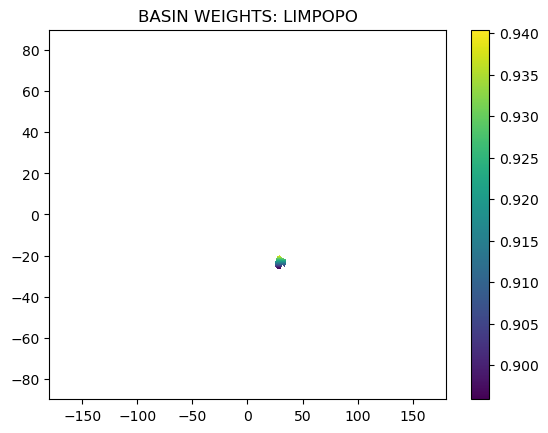

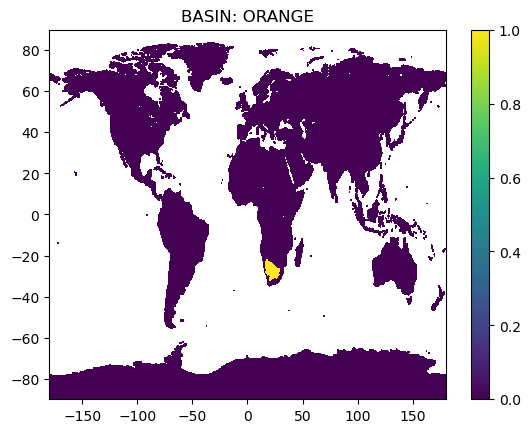

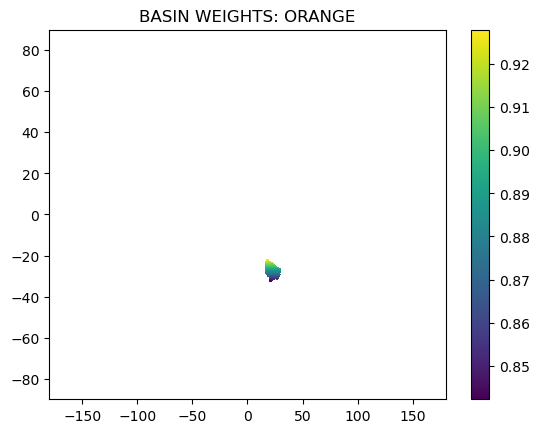

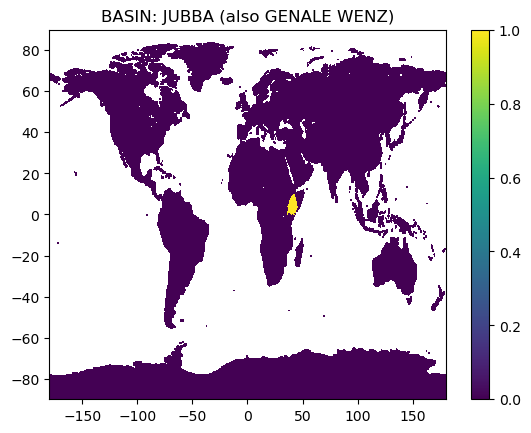

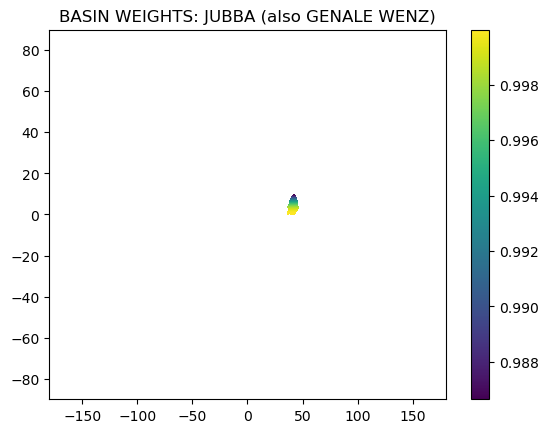

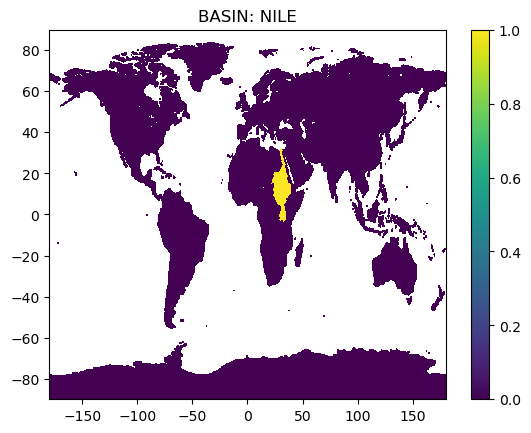

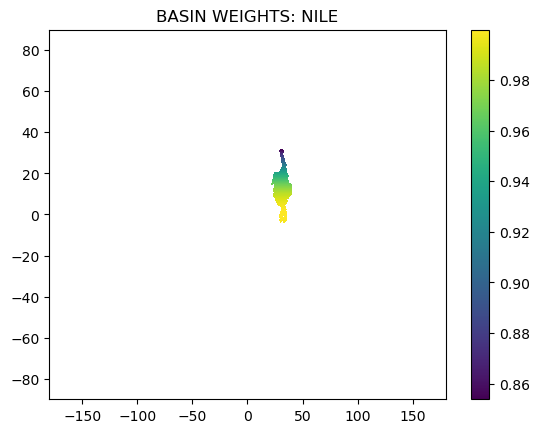

In [5]:
# (1) Create a land sea mask for the current dataset
fname_in  = '../../../GEODATA/GLEAM/v3.8a/SMroot_1980-2022_GLEAM_v3.8a_MO.nc'
data_nc   = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon       = data_nc.variables['lon'][:] # get values
lat       = data_nc.variables['lat'][:] # get values
mask_data = np.squeeze(data_nc.variables['SMroot'][0,:,:]) # get values
# Time information
nctime    = data_nc.variables['time'][:]     # time data
unit_time = data_nc.variables['time'].units  # units
cal_time  = data_nc.variables['time'].calendar
data_nc.close()

# Load Root Zone and Surface soil moisture data
# Root Zone
fname_in  = '../../../GEODATA/GLEAM/v3.8a/SMroot_1980-2022_GLEAM_v3.8a_MO.nc'
data_nc   = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon       = data_nc.variables['lon'][:] # get values
lat       = data_nc.variables['lat'][:] # get values
smroot    = np.squeeze(data_nc.variables['SMroot'][:]) # get values
data_nc.close()
# Surface
fname_in  = '../../../GEODATA/GLEAM/v3.8a/SMsurf_1980-2022_GLEAM_v3.8a_MO.nc'
data_nc   = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon       = data_nc.variables['lon'][:] # get values
lat       = data_nc.variables['lat'][:] # get values
smsurf    = np.squeeze(data_nc.variables['SMsurf'][:]) # get values
data_nc.close()

# Loop through and pull out year and month vectors from datetime object. 
# I will use these for indexing the 20th Century Reanalysis Data
yr_vect  = np.zeros(np.shape(nctime))
mon_vect = np.zeros(np.shape(nctime))

# Create Year and Month Vectors
for i_date in enumerate(nctime):
    yr_vect[i_date[0]]  = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).year
    mon_vect[i_date[0]] = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).month

# Create binary mask for ocean grid cells
mask_data = (mask_data.data)
mask_data[mask_data<0]=np.nan
mask_data[mask_data>=0]=1.0
plt.figure(),plt.pcolormesh(lon,lat,mask_data),plt.colorbar()

# Create latitude/longitude weighting mask
# Use land sea mask to create area weighting
lat_wts    = (np.cos(np.radians(lat)))
wts_global = np.expand_dims(lat_wts,1)*mask_data
plt.figure(),plt.title('area weights'),plt.pcolor(lon,lat,wts_global,vmin=0,vmax=1),plt.colorbar()

# Lon and lat resolution (for basin mask)
lat_res = 0.25
lon_res = 0.25

# Years Covered By Data
yrs_data = np.arange(1980,2022+1)

# LOOP THOUGH EACH BASIN
for n_basin in enumerate(basin_list):
    # Pull out current basin name
    curr_basin = n_basin[1]; print(curr_basin)

    # Create Initial mask for current basin
    # Create Mask
    out_grid = make_geocube(
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='COLORADO (also COLORADO RIVER)'],
        vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']==curr_basin],
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='MEKONG'],
        measurements=["value"],
        #resolution=(-0.25, 0.25),
        resolution=(lat_res, lon_res),
        fill=0
        )
    
    # Pull out lat/lon/mask as numpy arrays: make sure lat orientation matches dataset (use flipud if needed)
    lat_cnt  = np.flip(np.array(out_grid.y));  # lat_cnt = np.round(lat_cnt*100)/100
    lon_cnt  = np.array(out_grid.x);  # lon_cnt = np.round(lon_cnt*100)/100
    grid_cnt = np.flipud(np.array(out_grid.value))
    #plt.figure(),plt.pcolor(lon_cnt,lat_cnt,grid_cnt)
        
    # Overlapping lat/lons
    # Set lat/lons to copy
    i_lat = np.nonzero(np.in1d(lat,lat_cnt))[0]
    i_lon = np.nonzero(np.in1d(lon,lon_cnt))[0]
    
    # Apply to global lsmask
    lsmask_basin = mask_data.copy()
    lsmask_basin[np.ix_(i_lat,i_lon)] = lsmask_basin[np.ix_(i_lat,i_lon)]+grid_cnt
    lsmask_basin[np.where(lsmask_basin==1)]=0.0
    lsmask_basin[np.where(lsmask_basin==2)]=1
    plt.figure(),plt.title('BASIN: '+curr_basin),plt.pcolor(lon,lat,lsmask_basin),plt.colorbar()
    lsmask_basin[np.where(lsmask_basin==0)]=np.nan
    
    # Apply to area weighting
    wts_basin = wts_global*lsmask_basin
    plt.figure(),plt.title('BASIN WEIGHTS: '+curr_basin),plt.pcolor(lon,lat,wts_basin),plt.colorbar()    
    
    # Year/Month Loop to load in data
    smsurf_out = np.zeros((yrs_data.size,mons.size))
    smroot_out = np.zeros((yrs_data.size,mons.size))
    
    # Year/mon loops
    for n_yr in enumerate(yrs_data):
                
        # Month Loop
        for n_mon in enumerate(mons):
            
            # Find current yr+mon
            i_yr_mon = np.where( (yr_vect==n_yr[1]) & (mon_vect==n_mon[1]) )[0]
            
            # Pull out current month of data
            curr_smsurf = np.squeeze(smsurf[i_yr_mon,:,:].copy())
            curr_smroot = np.squeeze(smroot[i_yr_mon,:,:].copy())
              
            # Weighted average
            smsurf_out[n_yr[0],n_mon[0]] = np.nansum(curr_smsurf*wts_basin)/np.nansum(wts_basin)
            smroot_out[n_yr[0],n_mon[0]] = np.nansum(curr_smroot*wts_basin)/np.nansum(wts_basin)
    
    # Save dataframes and export to csv file
    # Surface Soil Moisture
    data_out = np.hstack((np.expand_dims(yrs_data,1),smsurf_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/smsurf_gleam_mm3_mm3_'+curr_basin+'.csv',index=False)

    # Root Zone Soil Moisture
    data_out = np.hstack((np.expand_dims(yrs_data,1),smroot_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/smroot_gleam_mm3_mm3_'+curr_basin+'.csv',index=False)

    

## LAI (GIMMS 4G)

LIMPOPO
ORANGE
JUBBA (also GENALE WENZ)
NILE


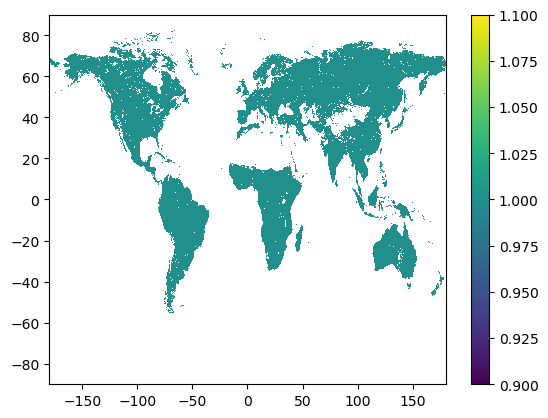

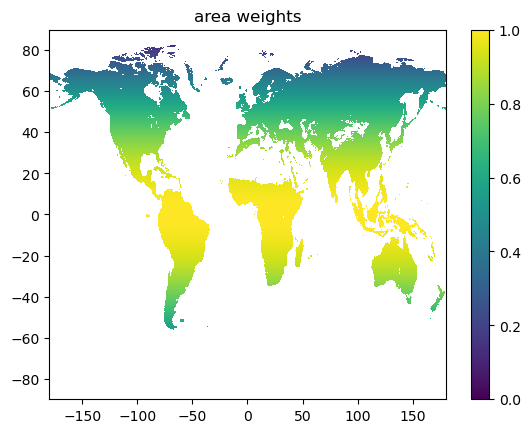

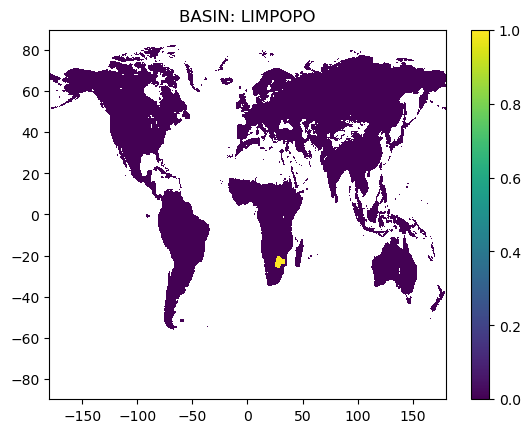

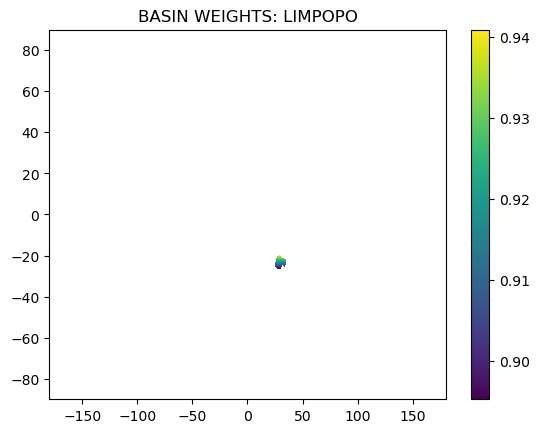

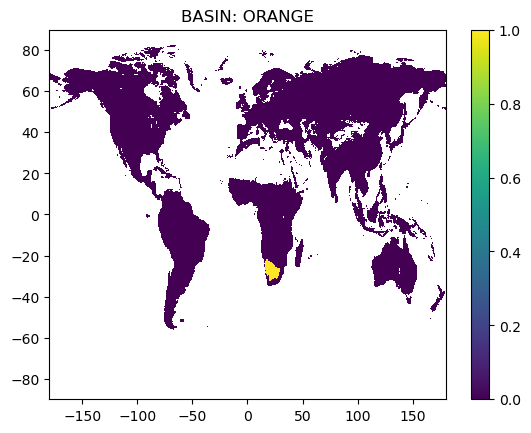

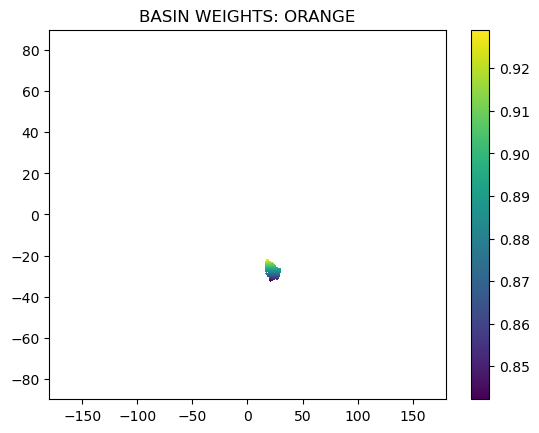

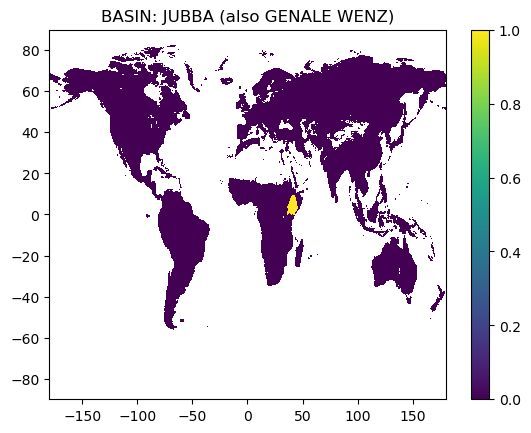

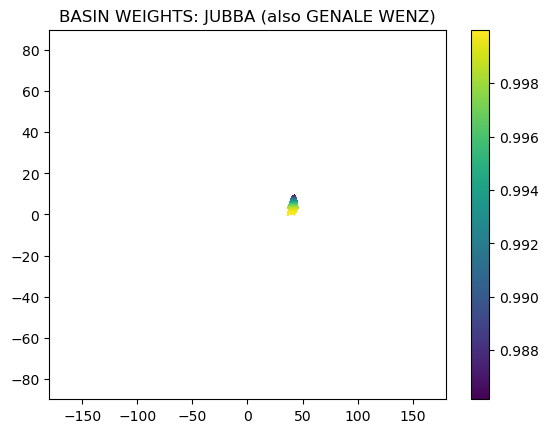

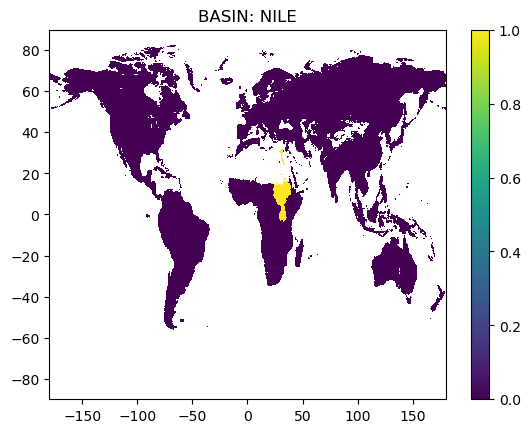

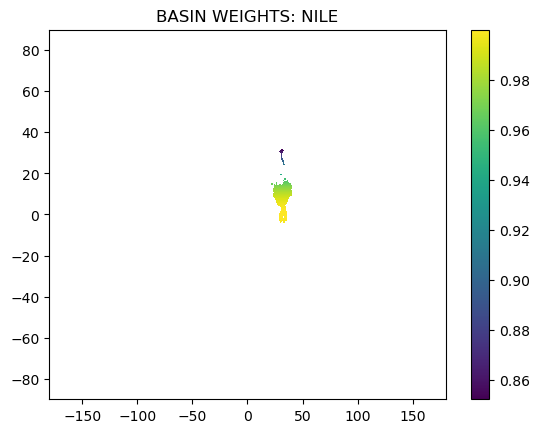

In [6]:
# (1) Create a land sea mask for the current dataset
fname_in  = '../../../GEODATA/GIMMSLAI4g/data/netcdf/native/lai4g_mon_2020.nc'
data_nc   = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon       = data_nc.variables['lon'][:] # get values
lat       = data_nc.variables['lat'][:] # get values
mask_data = np.squeeze(data_nc.variables['LAI'][:]) # get values
mask_data = np.nanmax(mask_data,axis=0)
data_nc.close()

# Create binary mask for ocean grid cells
mask_data = (mask_data.data)
mask_data[mask_data<0]=np.nan
mask_data[mask_data>=0]=1.0
plt.figure(),plt.pcolormesh(lon,lat,mask_data),plt.colorbar()

# Create latitude/longitude weighting mask
# Use land sea mask to create area weighting
lat_wts    = (np.cos(np.radians(lat)))
wts_global = np.expand_dims(lat_wts,1)*mask_data
plt.figure(),plt.title('area weights'),plt.pcolor(lon,lat,wts_global,vmin=0,vmax=1),plt.colorbar()

# Lon and lat resolution (for basin mask)
lat_res = 0.0833333333333
lon_res = 0.0833333333333

# Create uniform spaces lat/lons (minor precisions issues, so slightly uneven spacing in data)
# make sure only goes to 3 decimal places
lat = np.arange(89.95833333,-90,-1*lat_res); lat = np.around(lat,3)
lon = np.arange(-179.95833333,180,lon_res);  lon = np.around(lon,3)

# Years Covered By Data
yrs_data = np.arange(1982,2020+1)

# LOOP THOUGH EACH BASIN
for n_basin in enumerate(basin_list):
    # Pull out current basin name
    curr_basin = n_basin[1]; print(curr_basin)

    # Create Initial mask for current basin
    # Create Mask
    out_grid = make_geocube(
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='COLORADO (also COLORADO RIVER)'],
        vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']==curr_basin],
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='MEKONG'],
        measurements=["value"],
        #resolution=(-0.25, 0.25),
        resolution=(lat_res, lon_res),
        fill=0
        )
    
    # Pull out lat/lon/mask as numpy arrays: make sure lat orientation matches dataset (use flipud if needed)
    lat_cnt  = np.flip(np.array(out_grid.y));  lat_cnt = np.around(lat_cnt,3)
    lon_cnt  = np.array(out_grid.x);           lon_cnt = np.around(lon_cnt,3)
    grid_cnt = np.flipud(np.array(out_grid.value))
    #plt.figure(),plt.pcolor(lon_cnt,lat_cnt,grid_cnt)
        
    # Overlapping lat/lons
    # Set lat/lons to copy
    i_lat = np.nonzero(np.in1d(lat,lat_cnt))[0]
    i_lon = np.nonzero(np.in1d(lon,lon_cnt))[0]
    
    # Apply to global lsmask
    lsmask_basin = mask_data.copy()
    lsmask_basin[np.ix_(i_lat,i_lon)] = lsmask_basin[np.ix_(i_lat,i_lon)]+grid_cnt
    lsmask_basin[np.where(lsmask_basin==1)]=0.0
    lsmask_basin[np.where(lsmask_basin==2)]=1
    plt.figure(),plt.title('BASIN: '+curr_basin),plt.pcolor(lon,lat,lsmask_basin),plt.colorbar()
    lsmask_basin[np.where(lsmask_basin==0)]=np.nan
    
    # Apply to area weighting
    wts_basin = wts_global*lsmask_basin
    plt.figure(),plt.title('BASIN WEIGHTS: '+curr_basin),plt.pcolor(lon,lat,wts_basin),plt.colorbar()    
    
    # Year/Month Loop to load in data
    lai_out = np.zeros((yrs_data.size,mons.size))
    
    # Year/mon loops
    for n_yr in enumerate(yrs_data):
        
        # Text string for datafile
        str_datafile = '/Users/bcook/Dropbox/GEODATA/GIMMSLAI4g/data/netcdf/native/lai4g_mon_'+str(n_yr[1])+'.nc'
        #print(str_datafile)
        data_nc      = netCDF4.Dataset(str_datafile,"r",format="NETCDF4")
        lai_data    = np.squeeze(data_nc.variables['LAI'][:]) # get values
        data_nc.close()
            
        # Month Loop
        for n_mon in enumerate(mons):    
            # Find current month
            i_mon = np.where(mons==n_mon[1])[0]
            
            # Pull out current month of LAI
            curr_lai = np.squeeze(lai_data[i_mon,:,:].copy())
            
            # Weighted average
            lai_out[n_yr[0],n_mon[0]] = np.nansum(curr_lai*wts_basin)/np.nansum(wts_basin)
    
    # Save dataframe and export to csv file
    data_out = np.hstack((np.expand_dims(yrs_data,1),lai_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/lai_gimms4g_m2_m2_'+curr_basin+'.csv',index=False)

    

## GRACE-RLO6 TWS
* same dimensions as GLEAM, so use that land/sea mask

LIMPOPO
ORANGE
JUBBA (also GENALE WENZ)
NILE


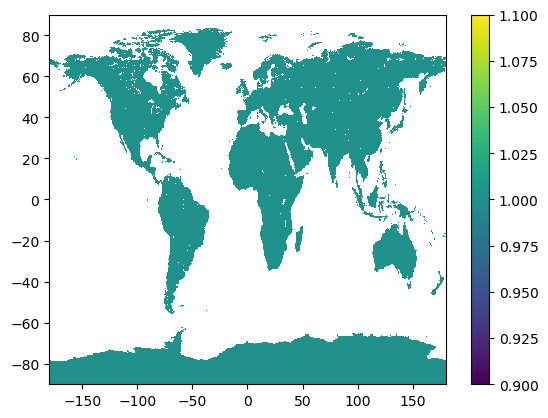

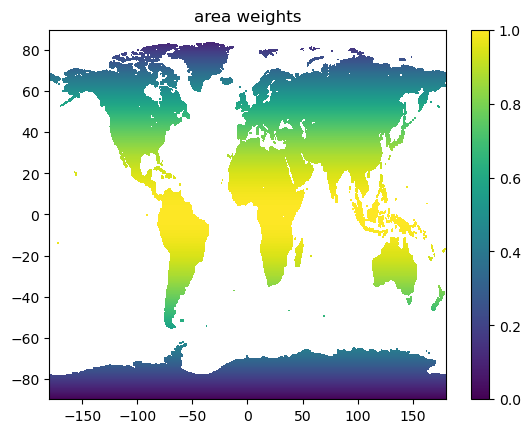

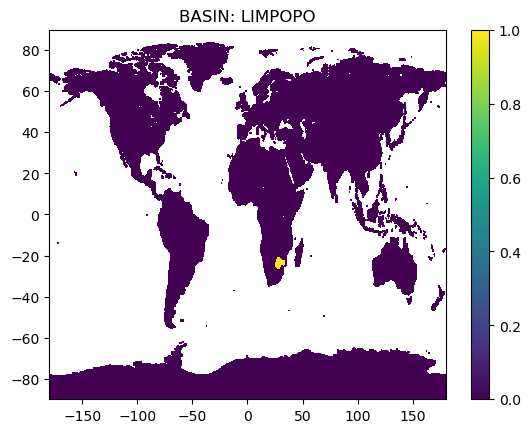

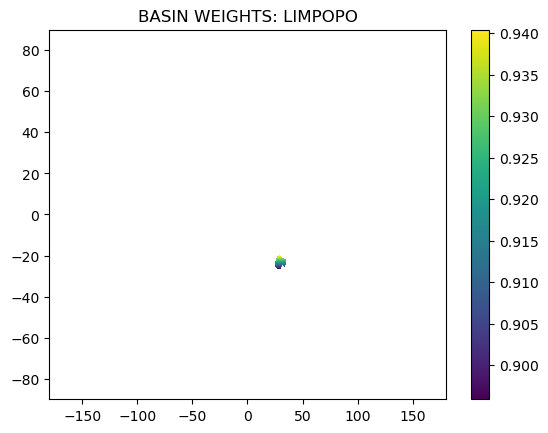

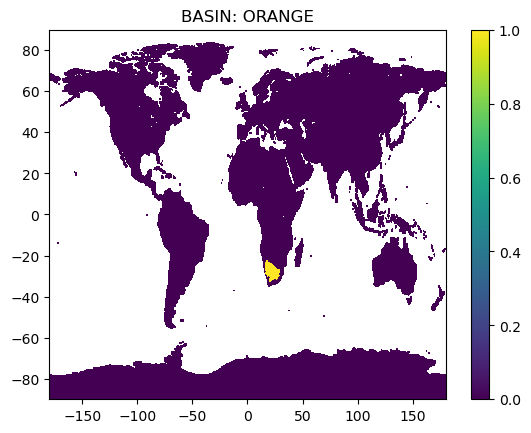

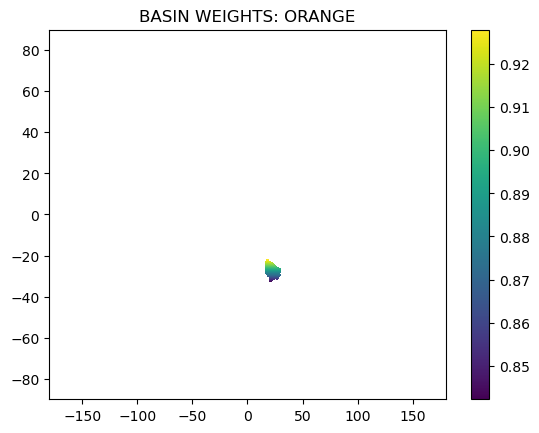

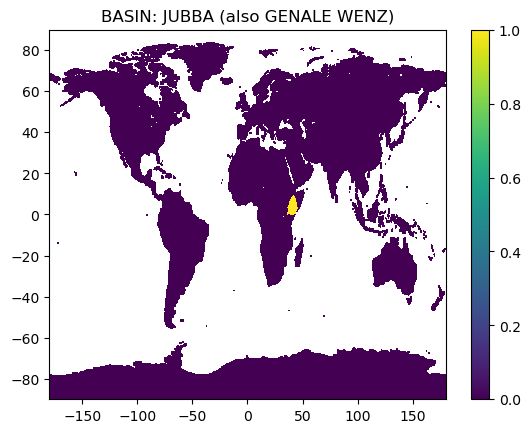

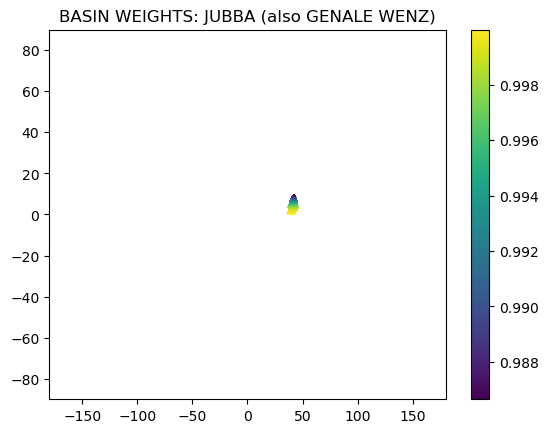

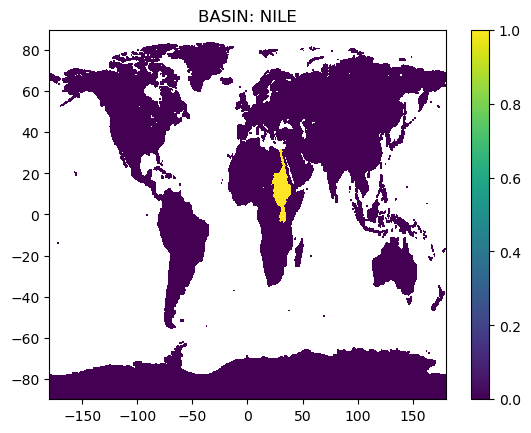

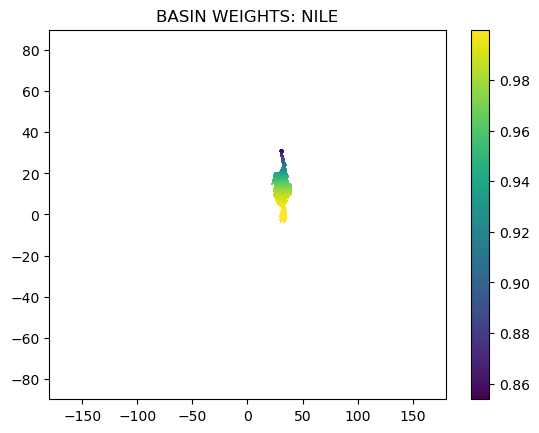

In [7]:
# (1) Load GRACE Liquid Water Equivalent
fname_in  = '../../../GEODATA/GRACE-RL06/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc'
data_nc   = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon       = data_nc.variables['lon'][:] # get values
lat       = data_nc.variables['lat'][:] # get values
grace_lwe = np.squeeze(data_nc.variables['lwe_thickness'][:]) # get values
# Time information
nctime    = data_nc.variables['time'][:]     # time data
unit_time = data_nc.variables['time'].Units  # units
cal_time  = data_nc.variables['time'].calendar
data_nc.close()

# Center on Greenwhich
# Recentering on Greenwhich
i_west    = np.where(lon>=180)[0]
i_east    = np.where(lon<180)[0]
lon       = lon-180
grace_lwe = np.concatenate((grace_lwe[:,:,i_west],grace_lwe[:,:,i_east]),axis=2)

# Loop through and pull out year and month vectors from datetime object. 
# I will use these for indexing the 20th Century Reanalysis Data
yr_vect  = np.zeros(np.shape(nctime))
mon_vect = np.zeros(np.shape(nctime))

# Create Year and Month Vectors
for i_date in enumerate(nctime):
    yr_vect[i_date[0]]  = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).year
    mon_vect[i_date[0]] = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).month

# Create a land sea mask for the current dataset
# USE GLEAM FOR THIS
fname_in  = '../../../GEODATA/GLEAM/v3.8a/SMroot_1980-2022_GLEAM_v3.8a_MO.nc'
data_nc   = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
#lon_gleam       = data_nc.variables['lon'][:] # get values
#lat_gleam       = data_nc.variables['lat'][:] # get values
mask_data = np.squeeze(data_nc.variables['SMroot'][0,:,:]) # get values
mask_data = np.flipud(mask_data)
data_nc.close()

# Create binary mask for ocean grid cells
mask_data = (mask_data.data)
mask_data[mask_data<0]=np.nan
mask_data[mask_data>=0]=1.0
plt.figure(),plt.pcolormesh(lon,lat,mask_data),plt.colorbar()

# Create latitude/longitude weighting mask
# Use land sea mask to create area weighting
lat_wts    = (np.cos(np.radians(lat)))
wts_global = np.expand_dims(lat_wts,1)*mask_data
plt.figure(),plt.title('area weights'),plt.pcolor(lon,lat,wts_global,vmin=0,vmax=1),plt.colorbar()

# Lon and lat resolution (for basin mask)
lat_res = 0.25
lon_res = 0.25

# Years Covered By Data
yrs_data = np.arange(2002,2023+1)

# LOOP THOUGH EACH BASIN
for n_basin in enumerate(basin_list):
    # Pull out current basin name
    curr_basin = n_basin[1]; print(curr_basin)

    # Create Initial mask for current basin
    # Create Mask
    out_grid = make_geocube(
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='COLORADO (also COLORADO RIVER)'],
        vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']==curr_basin],
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='MEKONG'],
        measurements=["value"],
        #resolution=(-0.25, 0.25),
        resolution=(lat_res, lon_res),
        fill=0
        )
    
    # Pull out lat/lon/mask as numpy arrays: make sure lat orientation matches dataset (use flipud if needed)
    lat_cnt  = (np.array(out_grid.y));  lat_cnt = np.around(lat_cnt,3)
    lon_cnt  = np.array(out_grid.x);           lon_cnt = np.around(lon_cnt,3)
    grid_cnt = (np.array(out_grid.value))
    #plt.figure(),plt.pcolor(lon_cnt,lat_cnt,grid_cnt)
        
    # Overlapping lat/lons
    # Set lat/lons to copy
    i_lat = np.nonzero(np.in1d(lat,lat_cnt))[0]
    i_lon = np.nonzero(np.in1d(lon,lon_cnt))[0]
    
    # Apply to global lsmask
    lsmask_basin = mask_data.copy()
    lsmask_basin[np.ix_(i_lat,i_lon)] = lsmask_basin[np.ix_(i_lat,i_lon)]+grid_cnt
    lsmask_basin[np.where(lsmask_basin==1)]=0.0
    lsmask_basin[np.where(lsmask_basin==2)]=1
    plt.figure(),plt.title('BASIN: '+curr_basin),plt.pcolor(lon,lat,lsmask_basin),plt.colorbar()
    lsmask_basin[np.where(lsmask_basin==0)]=np.nan
    
    # Apply to area weighting
    wts_basin = wts_global*lsmask_basin
    plt.figure(),plt.title('BASIN WEIGHTS: '+curr_basin),plt.pcolor(lon,lat,wts_basin),plt.colorbar()    
    
    # Year/Month Loop to load in data
    grace_out = np.zeros((yrs_data.size,mons.size))*np.nan
    
    # Year/mon loops
    for n_yr in enumerate(yrs_data):
                
        # Month Loop
        for n_mon in enumerate(mons):
            
            # Find current yr+mon
            i_yr_mon = np.where( (yr_vect==n_yr[1]) & (mon_vect==n_mon[1]) )[0]
            
            # If this time step is available
            if len(i_yr_mon)>0:
                # Pull out current month of data
                curr_grace = np.squeeze(grace_lwe[i_yr_mon,:,:].copy())
              
                # Weighted average
                grace_out[n_yr[0],n_mon[0]] = np.nansum(curr_grace*wts_basin)/np.nansum(wts_basin)
    
    # Save dataframes and export to csv file
    # Surface Soil Moisture
    data_out = np.hstack((np.expand_dims(yrs_data,1),grace_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/grace_lwe_cm_'+curr_basin+'.csv',na_rep='nan',index=False)


## GLWS2 Data

LIMPOPO
ORANGE
JUBBA (also GENALE WENZ)
NILE


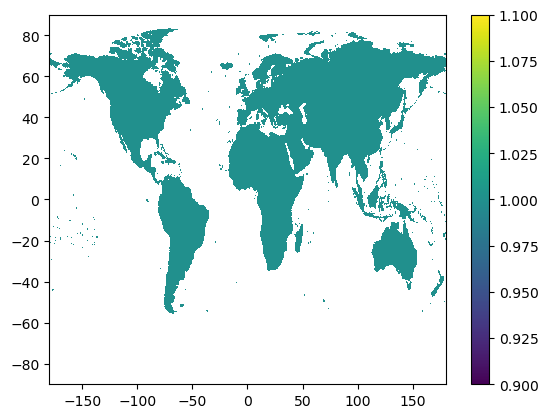

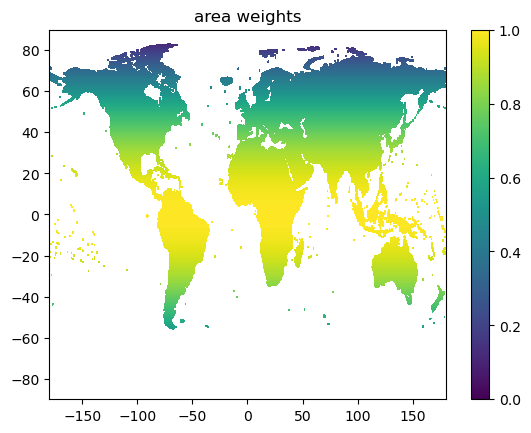

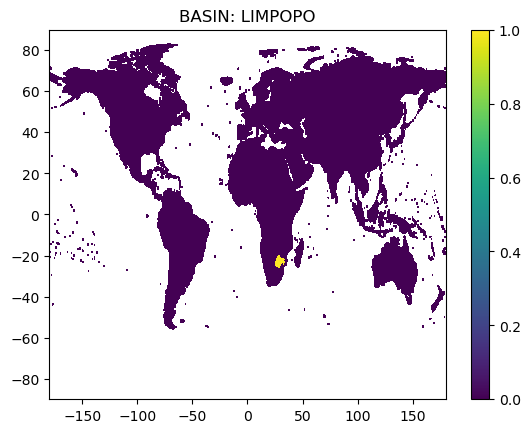

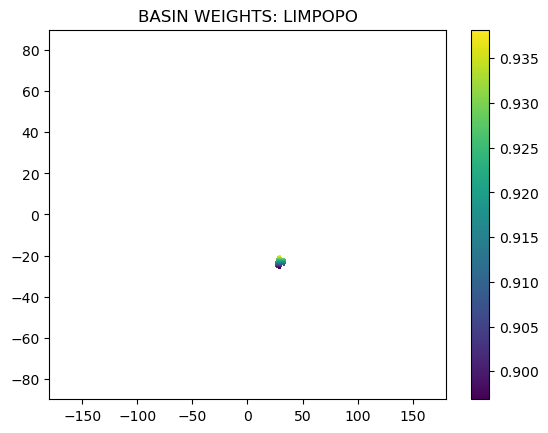

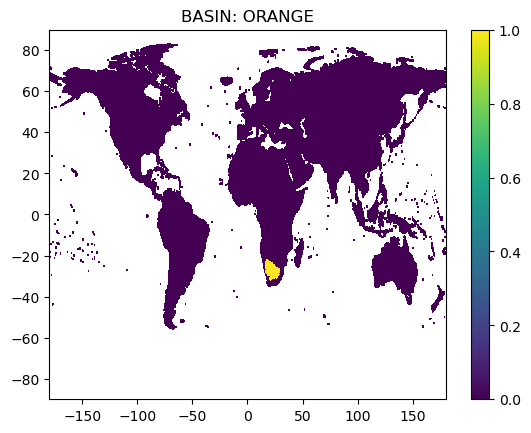

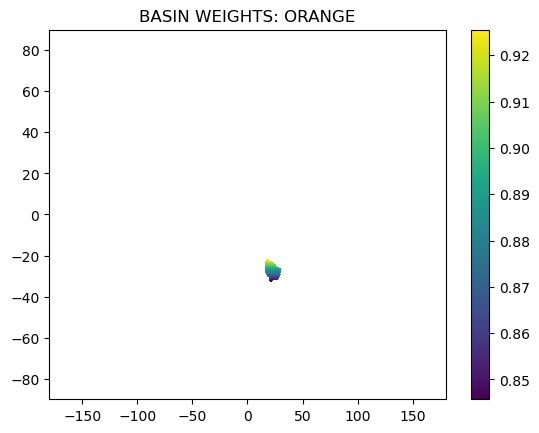

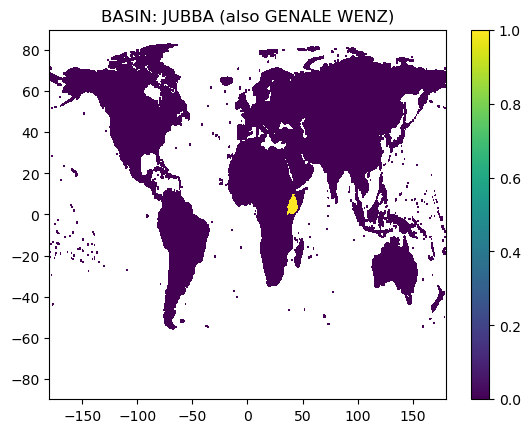

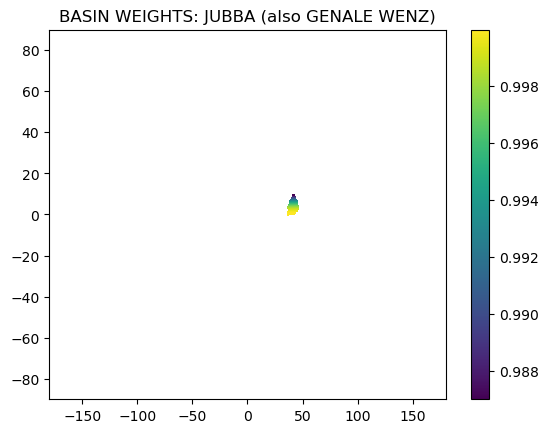

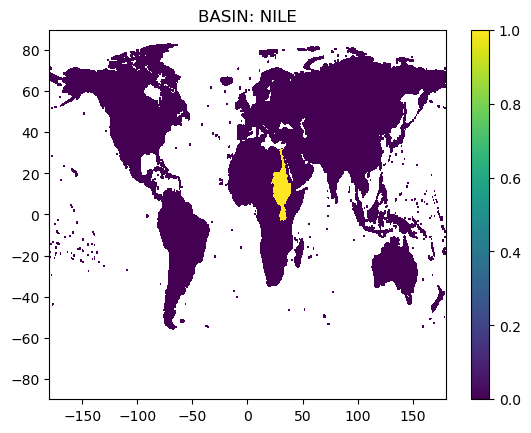

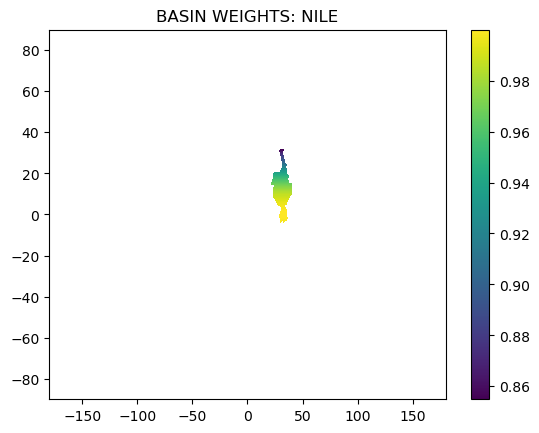

In [8]:
# (1) Load GLWS2 Data
fname_in     = '../../../GEODATA/GLWS20/data/GLWS_2_0_2003-2019_ensemble_median.nc'
data_nc      = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon          = data_nc.variables['longitude'][:] # get values
lat          = data_nc.variables['latitude'][:] # get values
glws2_gwater = np.squeeze(data_nc.variables['Groundwater'][:]) # get values
glws2_smoist = np.squeeze(data_nc.variables['Soil moisture'][:]) # get values
glws2_surfw  = np.squeeze(data_nc.variables['Surface water'][:]) # get values
glws2_twsa   = np.squeeze(data_nc.variables['Total water storage anomalies'][:]) # get values
data_nc.close()

# Create binary mask for ocean grid cells
mask_data = (glws2_gwater[10,:,:].data)
#mask_data[mask_data<0]=np.nan
mask_data[mask_data>=0]=1.0
mask_data[mask_data<=0]=1.0
plt.figure(),plt.pcolormesh(lon,lat,mask_data),plt.colorbar()

# Create latitude/longitude weighting mask
# Use land sea mask to create area weighting
lat_wts    = (np.cos(np.radians(lat)))
wts_global = np.expand_dims(lat_wts,1)*mask_data
plt.figure(),plt.title('area weights'),plt.pcolor(lon,lat,wts_global,vmin=0,vmax=1),plt.colorbar()

# Not nctime compliant, so create Year and Month vectors
yr_vect  = np.repeat(np.arange(2003,2019+1),12)
mon_vect = np.tile(np.arange(1,12+1),np.unique(yr_vect).size)

# Lon and lat resolution (for basin mask)
# use sign on lat_res to properly orient with dataset
lat_res = -0.5
lon_res = 0.5

# Years Covered By Data
yrs_data = np.arange(2003,2019+1)

# LOOP THOUGH EACH BASIN
for n_basin in enumerate(basin_list):
    # Pull out current basin name
    curr_basin = n_basin[1]; print(curr_basin)

    # Create Initial mask for current basin
    # Create Mask
    out_grid = make_geocube(
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='COLORADO (also COLORADO RIVER)'],
        vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']==curr_basin],
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='MEKONG'],
        measurements=["value"],
        #resolution=(-0.25, 0.25),
        resolution=(lat_res, lon_res),
        fill=0
        )
    
    # Pull out lat/lon/mask as numpy arrays: make sure lat orientation matches dataset (use flipud if needed)
    lat_cnt  = np.array(out_grid.y);  lat_cnt = np.around(lat_cnt,3)
    lon_cnt  = np.array(out_grid.x);           lon_cnt = np.around(lon_cnt,3)
    grid_cnt = np.array(out_grid.value)
    #plt.figure(),plt.pcolor(lon_cnt,lat_cnt,grid_cnt)
        
    # Overlapping lat/lons
    # Set lat/lons to copy
    i_lat = np.nonzero(np.in1d(lat,lat_cnt))[0]
    i_lon = np.nonzero(np.in1d(lon,lon_cnt))[0]
    
    # Apply to global lsmask
    lsmask_basin = mask_data.copy()
    lsmask_basin[np.ix_(i_lat,i_lon)] = lsmask_basin[np.ix_(i_lat,i_lon)]+grid_cnt
    lsmask_basin[np.where(lsmask_basin==1)]=0.0
    lsmask_basin[np.where(lsmask_basin==2)]=1
    plt.figure(),plt.title('BASIN: '+curr_basin),plt.pcolor(lon,lat,lsmask_basin),plt.colorbar()
    lsmask_basin[np.where(lsmask_basin==0)]=np.nan
    
    # Apply to area weighting
    wts_basin = wts_global*lsmask_basin
    plt.figure(),plt.title('BASIN WEIGHTS: '+curr_basin),plt.pcolor(lon,lat,wts_basin),plt.colorbar()    
    
    # Year/Month Loop to load in data
    # storage arrays
    glws2_gwater_out = np.zeros((yrs_data.size,mons.size))*np.nan
    glws2_smoist_out = np.zeros((yrs_data.size,mons.size))*np.nan
    glws2_surfw_out  = np.zeros((yrs_data.size,mons.size))*np.nan
    glws2_twsa_out   = np.zeros((yrs_data.size,mons.size))*np.nan

    # Year/mon loops
    for n_yr in enumerate(yrs_data):
                
        # Month Loop
        for n_mon in enumerate(mons):
            
            # Find current yr+mon
            i_yr_mon = np.where( (yr_vect==n_yr[1]) & (mon_vect==n_mon[1]) )[0]
            
            # If this time step is available
            if len(i_yr_mon)>0:
                # Pull out current month of data
                curr_glws2_gwater = np.squeeze(glws2_gwater[i_yr_mon,:,:].copy())
                curr_glws2_smoist = np.squeeze(glws2_smoist[i_yr_mon,:,:].copy())
                curr_glws2_surfw  = np.squeeze(glws2_surfw[i_yr_mon,:,:].copy())
                curr_glws2_twsa   = np.squeeze(glws2_twsa[i_yr_mon,:,:].copy())
              
                # Weighted average
                glws2_gwater_out[n_yr[0],n_mon[0]] = np.nansum(curr_glws2_gwater*wts_basin)/np.nansum(wts_basin)
                glws2_smoist_out[n_yr[0],n_mon[0]] = np.nansum(curr_glws2_smoist*wts_basin)/np.nansum(wts_basin)
                glws2_surfw_out[n_yr[0],n_mon[0]]  = np.nansum(curr_glws2_surfw*wts_basin)/np.nansum(wts_basin)
                glws2_twsa_out[n_yr[0],n_mon[0]]   = np.nansum(curr_glws2_twsa*wts_basin)/np.nansum(wts_basin)
    
    # Save dataframes and export to csv file
    # Groundwater
    data_out = np.hstack((np.expand_dims(yrs_data,1),glws2_gwater_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/glws2_gwater_mm_'+curr_basin+'.csv',na_rep='nan',index=False)
    # Soil Moisture
    data_out = np.hstack((np.expand_dims(yrs_data,1),glws2_smoist_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/glws2_soilmoist_mm_'+curr_basin+'.csv',na_rep='nan',index=False)
    # Surface Water
    data_out = np.hstack((np.expand_dims(yrs_data,1),glws2_surfw_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/glws2_surfacewater_mm_'+curr_basin+'.csv',na_rep='nan',index=False)
    # TWS anomalies
    data_out = np.hstack((np.expand_dims(yrs_data,1),glws2_twsa_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/glws2_tws_anom_mm_'+curr_basin+'.csv',na_rep='nan',index=False)


## GRUN Ensemble Data

LIMPOPO
ORANGE
JUBBA (also GENALE WENZ)
NILE


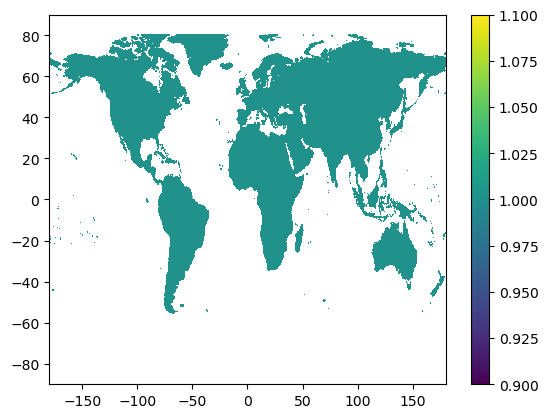

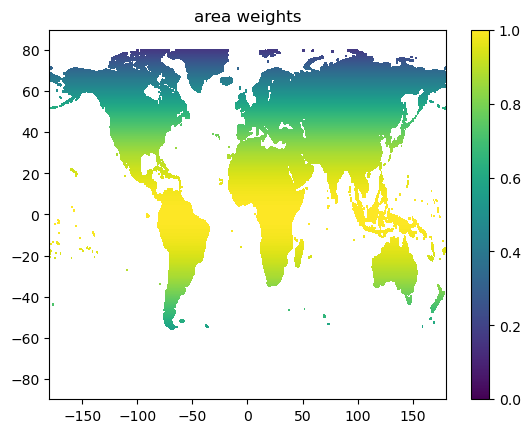

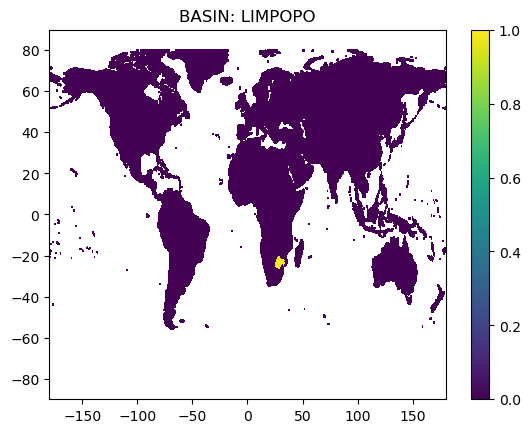

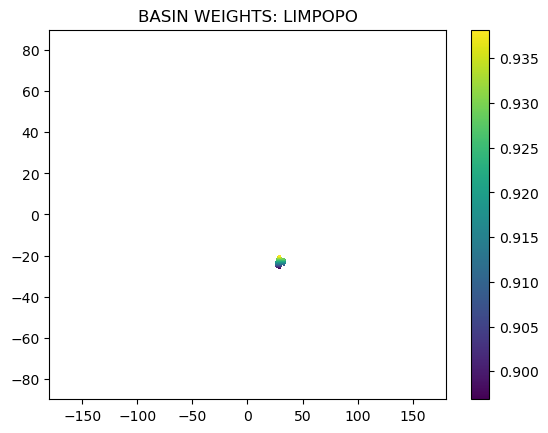

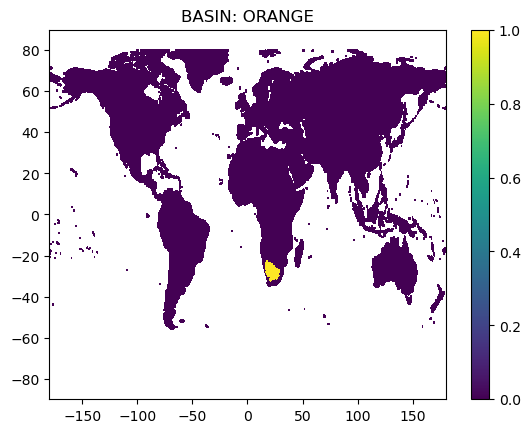

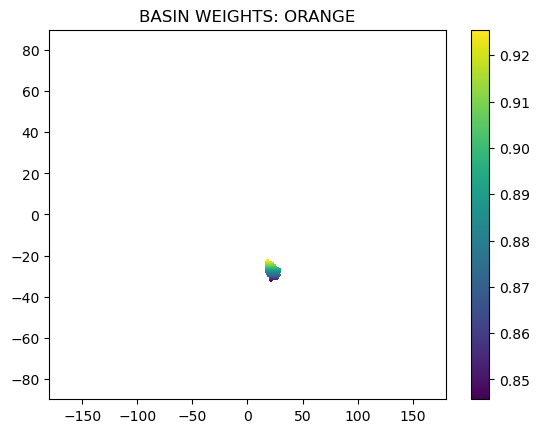

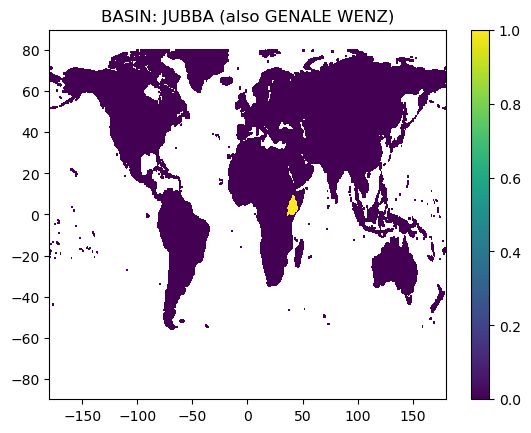

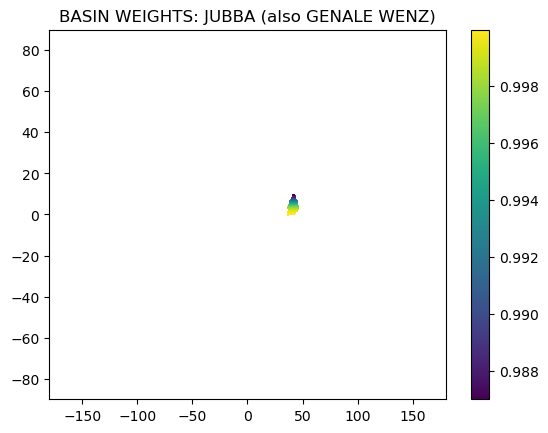

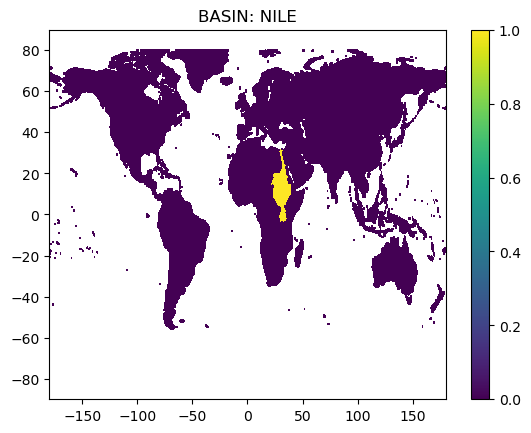

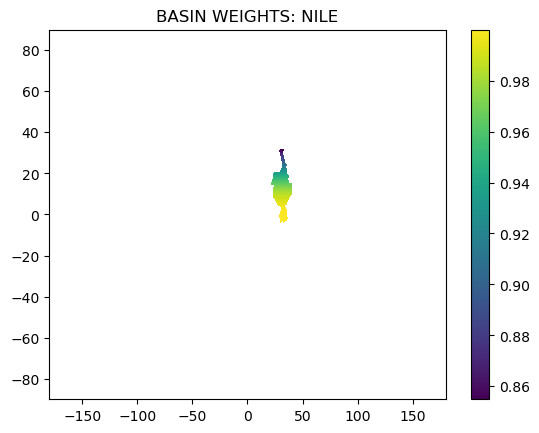

In [9]:
# (1) Load data and create a land sea mask for the current dataset
fname_in    = '../../../GEODATA/GRUN-ENS/data/G-RUN_ENSEMBLE_MMM.nc'
data_nc     = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
lon         = data_nc.variables['X'][:] # get values
lat         = data_nc.variables['Y'][:] # get values
runoff_data = np.squeeze(data_nc.variables['Runoff'][:]) # get values
# Time information
nctime    = data_nc.variables['time'][:]     # time data
unit_time = data_nc.variables['time'].units  # units
#cal_time  = data_nc.variables['time'].calendar
cal_time  = 'gregorian'
data_nc.close()

# Loop through and pull out year and month vectors from datetime object. 
# I will use these for indexing the 20th Century Reanalysis Data
yr_vect  = np.zeros(np.shape(nctime))
mon_vect = np.zeros(np.shape(nctime))

# Create Year and Month Vectors
for i_date in enumerate(nctime):
    yr_vect[i_date[0]]  = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).year
    mon_vect[i_date[0]] = netCDF4.num2date(nctime[i_date[0]],units=unit_time,calendar=cal_time).month

# Create binary mask for ocean grid cells
mask_data = copy.deepcopy(runoff_data[10,:,:].data)
mask_data[mask_data<0]=np.nan
mask_data[mask_data>=0]=1.0
plt.figure(),plt.pcolormesh(lon,lat,mask_data),plt.colorbar()

# Create latitude/longitude weighting mask
# Use land sea mask to create area weighting
lat_wts    = (np.cos(np.radians(lat)))
wts_global = np.expand_dims(lat_wts,1)*mask_data
plt.figure(),plt.title('area weights'),plt.pcolor(lon,lat,wts_global,vmin=0,vmax=1),plt.colorbar()

# Lon and lat resolution (for basin mask)
lat_res = -0.5
lon_res = 0.5

# Years Covered By Data
yrs_data = np.arange(1901,2019+1)

# LOOP THOUGH EACH BASIN
for n_basin in enumerate(basin_list):
    # Pull out current basin name
    curr_basin = n_basin[1]; print(curr_basin)

    # Create Initial mask for current basin
    # Create Mask
    out_grid = make_geocube(
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='COLORADO (also COLORADO RIVER)'],
        vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']==curr_basin],
        #vector_data=gdf_cnt[gdf_cnt['RIVER_BASI']=='MEKONG'],
        measurements=["value"],
        #resolution=(-0.25, 0.25),
        resolution=(lat_res, lon_res),
        fill=0
        )
    
    # Pull out lat/lon/mask as numpy arrays: make sure lat orientation matches dataset (use flipud if needed)
    lat_cnt  = np.flip(np.array(out_grid.y));  # lat_cnt = np.round(lat_cnt*100)/100
    lon_cnt  = np.array(out_grid.x);  # lon_cnt = np.round(lon_cnt*100)/100
    grid_cnt = np.flipud(np.array(out_grid.value))
    #plt.figure(),plt.pcolor(lon_cnt,lat_cnt,grid_cnt)
        
    # Overlapping lat/lons
    # Set lat/lons to copy
    i_lat = np.nonzero(np.in1d(lat,lat_cnt))[0]
    i_lon = np.nonzero(np.in1d(lon,lon_cnt))[0]
    
    # Apply to global lsmask
    lsmask_basin = mask_data.copy()
    lsmask_basin[np.ix_(i_lat,i_lon)] = lsmask_basin[np.ix_(i_lat,i_lon)]+grid_cnt
    lsmask_basin[np.where(lsmask_basin==1)]=0.0
    lsmask_basin[np.where(lsmask_basin==2)]=1
    plt.figure(),plt.title('BASIN: '+curr_basin),plt.pcolor(lon,lat,lsmask_basin),plt.colorbar()
    lsmask_basin[np.where(lsmask_basin==0)]=np.nan
    
    # Apply to area weighting
    wts_basin = wts_global*lsmask_basin
    plt.figure(),plt.title('BASIN WEIGHTS: '+curr_basin),plt.pcolor(lon,lat,wts_basin),plt.colorbar()    
    
    # Year/Month Loop to load in data
    runoff_out = np.zeros((yrs_data.size,mons.size))
    
    # Year/mon loops
    for n_yr in enumerate(yrs_data):
                
        # Month Loop
        for n_mon in enumerate(mons):
            
            # Find current yr+mon
            i_yr_mon = np.where( (yr_vect==n_yr[1]) & (mon_vect==n_mon[1]) )[0]
            
            # Pull out current month of data
            curr_runoff = np.squeeze(runoff_data[i_yr_mon,:,:].copy())
              
            # Weighted average
            runoff_out[n_yr[0],n_mon[0]] = np.nansum(curr_runoff*wts_basin)/np.nansum(wts_basin)
    
    # Save dataframes and export to csv file
    # Surface Soil Moisture
    data_out = np.hstack((np.expand_dims(yrs_data,1),runoff_out))
    df_out   = pd.DataFrame(columns=np.hstack(('Year',mons_txt)),data=data_out,index=None)
    df_out.to_csv('../dataproc/grun_ens_runoff_mm_day_'+curr_basin+'.csv',na_rep='nan',index=False)
